In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sagemaker import get_execution_role
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import PowerTransformer

plt.tight_layout()

from warnings import filterwarnings
filterwarnings('ignore')

<Figure size 640x480 with 0 Axes>

## Import the dataset:

In [32]:
role = get_execution_role()
bucket = 'ids-house-price'
all_data = '1553768847-housing.csv'
s3_route = 's3://{}/{}'.format(bucket, all_data)
data = pd.read_csv(s3_route)
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


## Working in the copy of the dataset:

In [33]:
df = data.copy()
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


## Basic Analysis:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [35]:
df.shape

(20640, 10)

## Summary Statistics for Categoric and Numeric Columns:

In [36]:
num = df.select_dtypes(include=np.number).columns.to_list()
num

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [37]:
cat = df.select_dtypes(exclude=np.number).columns.to_list()
cat

['ocean_proximity']

In [38]:
df[num].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [39]:
df[cat].describe()

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


## Checking the null values:

In [40]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

## Treating the null values:

In [14]:
df['total_bedrooms'].isna().sum()

207

In [15]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [41]:
a=round(df.groupby(['ocean_proximity'])['total_bedrooms'].mean()[1],0)
a

534.0

In [42]:
df["total_bedrooms"]=df["total_bedrooms"].fillna(a)

In [43]:
df['total_bedrooms'].isna().sum()

0

## Remove unwanted columns:

In [44]:
col = df.columns.to_list()
col

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity',
 'median_house_value']

In [45]:
df.drop(['longitude','latitude'],axis=1,inplace=True)

In [46]:
df

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...
20635,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,18,697,150.0,356,114,2.5568,INLAND,77100
20637,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,18,1860,409.0,741,349,1.8672,INLAND,84700


In [47]:
columns = df.columns.to_list()
columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity',
 'median_house_value']

In [48]:
coll = ['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']
coll

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

## Data Visualization:

### Univariate:

In [49]:
coll

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [50]:
cat

['ocean_proximity']

In [3]:
# for i in columns:
#     sns.histplot(df[i])
#     plt.show()

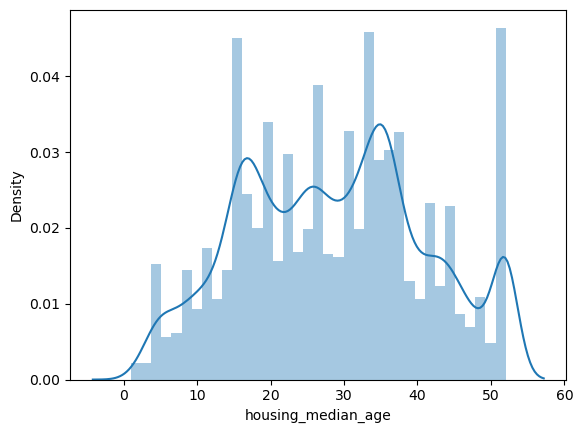

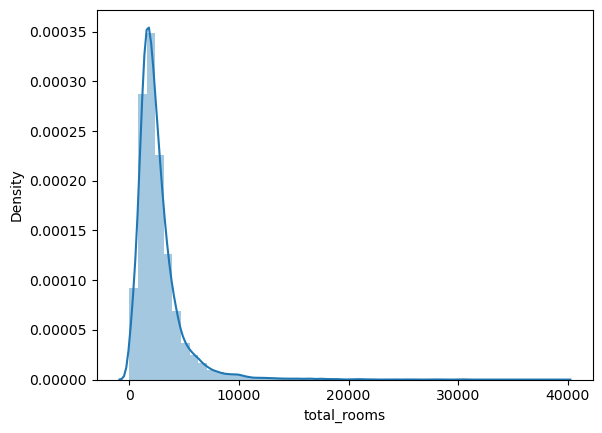

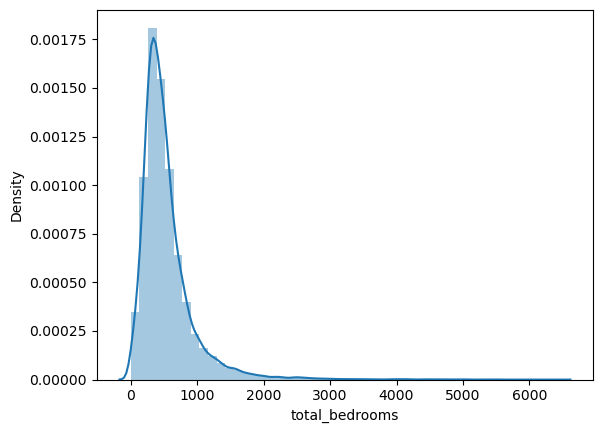

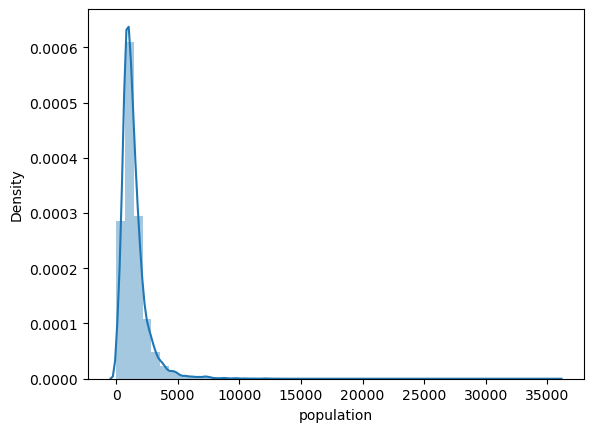

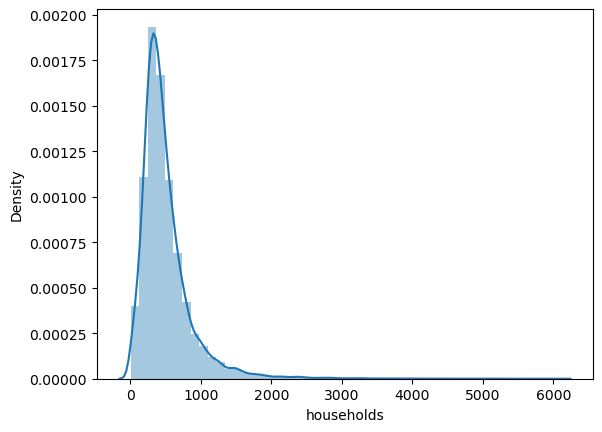

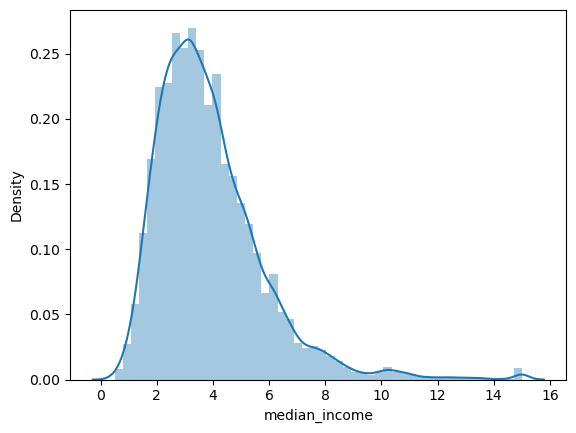

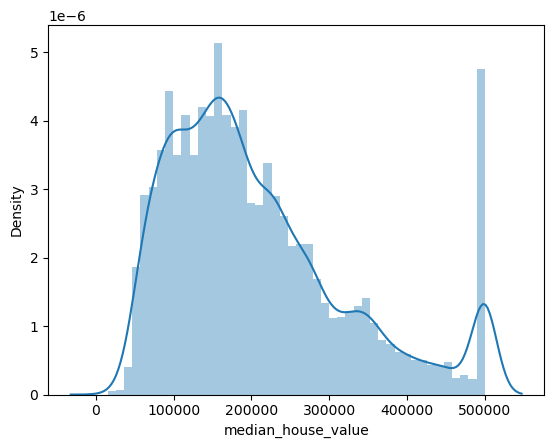

In [27]:
for i in coll:
    sns.distplot(df[i])
    plt.show()

In [1]:
# for i in coll:
#     sns.boxplot(y=df[i])
#     plt.show()

In [51]:
df[cat].value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

In [52]:
# sns.countplot(df['ocean_proximity'])
# plt.show()

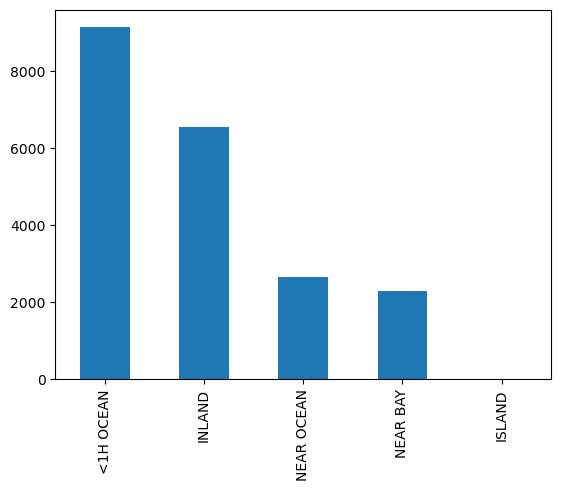

In [53]:
df['ocean_proximity'].value_counts().plot(kind='bar')
plt.show()

**Remove the Island, because it is of very lesser data comparing to other values**

## Removing the outliers:

In [54]:
dff = df[df['ocean_proximity'] != 'ISLAND']

In [55]:
dff

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...
20635,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,18,697,150.0,356,114,2.5568,INLAND,77100
20637,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,18,1860,409.0,741,349,1.8672,INLAND,84700


In [56]:
dff['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64

### Bivariate:

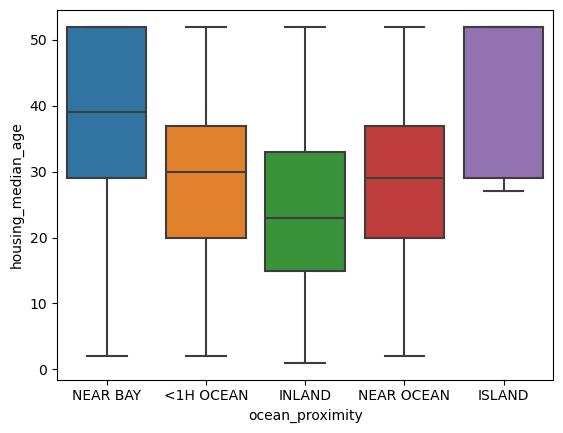

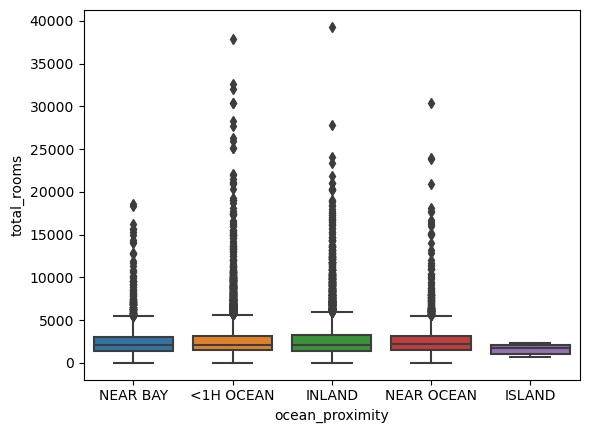

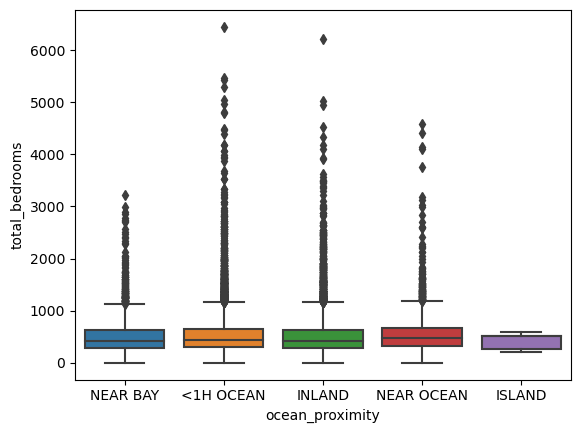

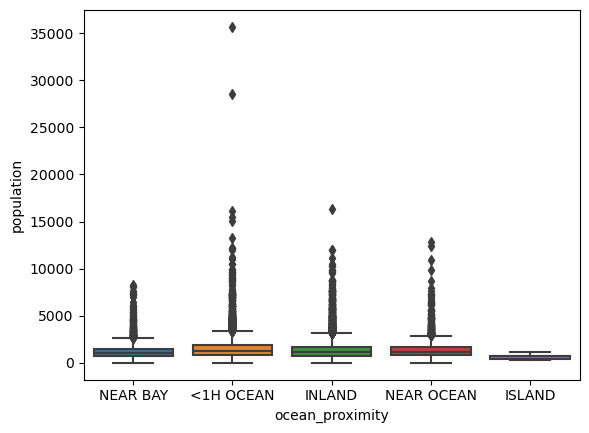

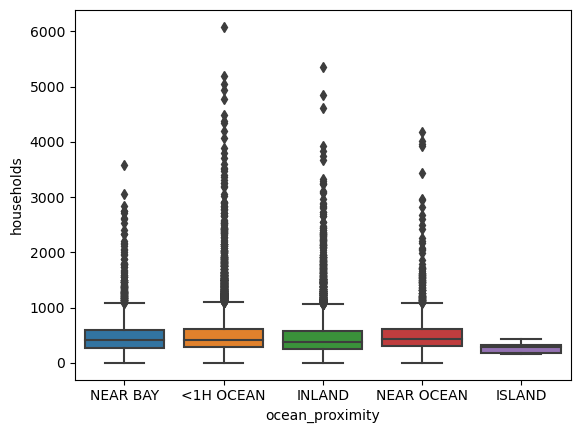

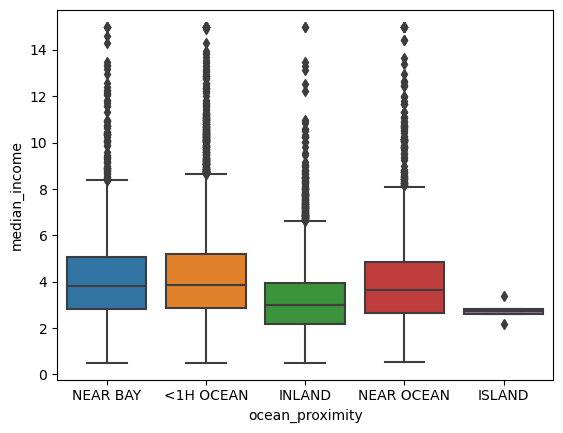

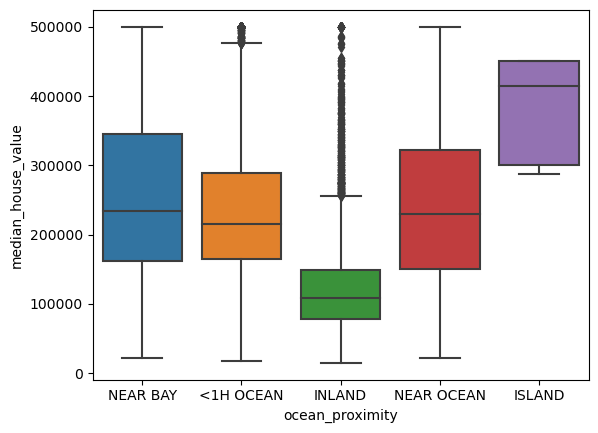

In [57]:
for i in coll:
    sns.boxplot(y=df[i],x=df['ocean_proximity'])
    plt.show()

In [58]:
c = ['households','total_rooms','total_bedrooms']

In [60]:
# for i in c:
#     sns.scatterplot(df[i],df['population'])
#     plt.show()

In [61]:
ind = ['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [62]:
dep = ['median_house_value']

In [2]:
# for i in ind:
#     sns.lmplot(data=dff, x=i , y='median_house_value')
#     plt.show()

### Multivariate:

In [64]:
coll

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

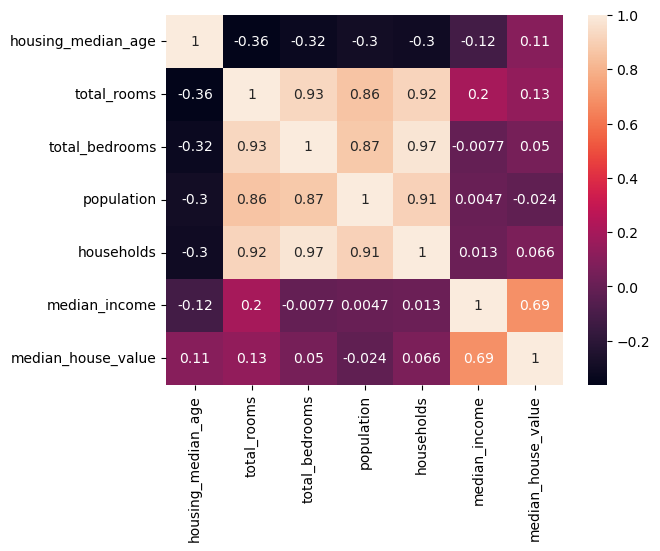

In [65]:
sns.heatmap(dff[coll].corr(),annot=True)
plt.show()

* The columns total_rooms, total_bedrooms, population, household are the columns which are highly correlated 
* This can be reduces by using Variance Inflation Factor(VIF)
* The column median_income has good coorlation with target

## Transformation:

In [66]:
dff.skew()

housing_median_age    0.060234
total_rooms           4.147029
total_bedrooms        3.476972
population            4.935778
households            3.410186
median_income         1.646332
median_house_value    0.978449
dtype: float64

In [67]:
dff.kurt()

housing_median_age    -0.800617
total_rooms           32.625833
total_bedrooms        22.235360
population            73.549995
households            22.054909
median_income          4.951122
median_house_value     0.330317
dtype: float64

Except the housing_median_age column all others are highly skewed so we need to transform it

In [68]:
trans = ['total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [69]:
from sklearn.preprocessing import PowerTransformer

In [70]:
p = PowerTransformer(method='box-cox')
dff[trans] = p.fit_transform(dff[trans])

In [71]:
dff

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,41,-1.157712,-1.577308,-1.618528,-1.517265,1.916138,NEAR BAY,452600
1,21,1.896468,1.441961,1.089862,1.634411,1.909542,NEAR BAY,358500
2,52,-0.534757,-1.135987,-1.139252,-1.134301,1.601800,NEAR BAY,352100
3,52,-0.713784,-0.876725,-0.999890,-0.877616,1.035764,NEAR BAY,341300
4,52,-0.399781,-0.653427,-0.984911,-0.665734,0.197837,NEAR BAY,342200
...,...,...,...,...,...,...,...,...
20635,25,-0.369255,-0.264491,-0.476856,-0.343959,-1.662547,INLAND,78100
20636,18,-1.419369,-1.410002,-1.511485,-1.624094,-0.663105,INLAND,77100
20637,17,0.045973,0.107148,-0.239930,0.040296,-1.492226,INLAND,92300
20638,18,-0.220634,-0.139032,-0.647960,-0.266852,-1.304363,INLAND,84700


In [72]:
dff.isna().sum()

housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

In [73]:
dff.skew()

housing_median_age    0.060234
total_rooms           0.123319
total_bedrooms        0.115053
population            0.113149
households            0.115985
median_income         0.004883
median_house_value    0.978449
dtype: float64

## Encoding:

In [74]:
df1 = pd.get_dummies(data=dff, columns = cat,drop_first=True)

In [75]:
df1

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41,-1.157712,-1.577308,-1.618528,-1.517265,1.916138,452600,0,1,0
1,21,1.896468,1.441961,1.089862,1.634411,1.909542,358500,0,1,0
2,52,-0.534757,-1.135987,-1.139252,-1.134301,1.601800,352100,0,1,0
3,52,-0.713784,-0.876725,-0.999890,-0.877616,1.035764,341300,0,1,0
4,52,-0.399781,-0.653427,-0.984911,-0.665734,0.197837,342200,0,1,0
...,...,...,...,...,...,...,...,...,...,...
20635,25,-0.369255,-0.264491,-0.476856,-0.343959,-1.662547,78100,1,0,0
20636,18,-1.419369,-1.410002,-1.511485,-1.624094,-0.663105,77100,1,0,0
20637,17,0.045973,0.107148,-0.239930,0.040296,-1.492226,92300,1,0,0
20638,18,-0.220634,-0.139032,-0.647960,-0.266852,-1.304363,84700,1,0,0


## Model Building:

In [76]:
df1

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41,-1.157712,-1.577308,-1.618528,-1.517265,1.916138,452600,0,1,0
1,21,1.896468,1.441961,1.089862,1.634411,1.909542,358500,0,1,0
2,52,-0.534757,-1.135987,-1.139252,-1.134301,1.601800,352100,0,1,0
3,52,-0.713784,-0.876725,-0.999890,-0.877616,1.035764,341300,0,1,0
4,52,-0.399781,-0.653427,-0.984911,-0.665734,0.197837,342200,0,1,0
...,...,...,...,...,...,...,...,...,...,...
20635,25,-0.369255,-0.264491,-0.476856,-0.343959,-1.662547,78100,1,0,0
20636,18,-1.419369,-1.410002,-1.511485,-1.624094,-0.663105,77100,1,0,0
20637,17,0.045973,0.107148,-0.239930,0.040296,-1.492226,92300,1,0,0
20638,18,-0.220634,-0.139032,-0.647960,-0.266852,-1.304363,84700,1,0,0


In [77]:
x = df1.drop(['median_house_value'],axis=1)
y = df1['median_house_value']

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=100)

In [80]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(14444, 9)
(14444,)
(6191, 9)
(6191,)


## Base Model:

In [81]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import GridSearchCV

In [82]:
xtrainc = sm.add_constant(xtrain)
xtestc = sm.add_constant(xtest)

In [83]:
basemodel = sm.OLS(ytrain,xtrainc).fit()
basemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     2451.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:02:47   Log-Likelihood:            -1.8211e+05
No. Observations:               14444   AIC:                         3.642e+05
Df Residuals:                   14434   BIC:                         3.643e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.945e+05   1881.527    103.384      0.000    1.91e+05    1.98e+05
housing_median_age          1156.7568     54.700     21.147      0.000    1049.537    1263.976
total_rooms                -1.686e+04   2662.618     -6.332      0.000   -2.21e+04   -1.16e+04
total_bedrooms              3.096e+04   3157.183      9.807      0.000    2.48e+04    3.72e+04
population                 -6.048e+04   1644.910    -36.767      0.000   -6.37e+04   -5.73e+04
households                  4.816e+04   3215.420     14.977      0.000    4.19e+04    5.45e+04
median_income               7.241e+04    954.735     75.838      0.000    7.05e+04    7.43e+04
ocean_proximity_INLAND     -7.001e+04   1647.759    -42.487      0.000   -7.32e+04   -6.68e+04
ocean_proximity_NEAR BAY    1259.7952   2086.374      0.604      0.546   -2829.766    5349.357
ocean_proximity_NEAR OCEAN   1.03e+04   1921.633      5.358      0.000    6529.539    1.41e+04
==============================================================================
Omnibus:                     3101.866   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9362.367
Skew:                           1.111   Prob(JB):                         0.00
Kurtosis:                       6.259   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The R square is 0.6 that is 60 percent of target can be explained by the independent variables
* The p value of all the columns are 0 that is less than 0.05 thus all columns are significant
* Thus we also check for multicollinearity

### Check for Multicollinearity using VIF

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [85]:
col1 = xtrainc.columns.to_list()
col1

['const',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [86]:
vif = [ VIF(xtrainc.values,i) for i in range(xtrainc.shape[1])]

In [87]:
vif_df = pd.DataFrame(vif,index=col1,columns=['VIF'])
vif_df.sort_values(by='VIF',ascending=False)

,VIF
households,29.036970
total_bedrooms,27.900273
total_rooms,19.818539
const,9.772517
population,7.584189
median_income,2.532366
ocean_proximity_INLAND,1.613604
housing_median_age,1.311950
ocean_proximity_NEAR BAY,1.206867
ocean_proximity_NEAR OCEAN,1.153040


**Remove the column households and then check for VIF**

In [88]:
xtrainc1 = xtrainc.drop('households',axis=1)
xtestc1 = xtestc.drop('households',axis=1)

In [89]:
col2 = xtrainc1.columns.to_list()
col2

['const',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'median_income',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [90]:
vif = [ VIF(xtrainc1.values,i) for i in range(xtrainc1.shape[1])]

In [91]:
vif_df = pd.DataFrame(vif,index=col2,columns=['VIF'])
vif_df.sort_values(by='VIF',ascending=False)

,VIF
total_rooms,19.297498
total_bedrooms,17.373498
const,9.762119
population,5.318374
median_income,2.527608
ocean_proximity_INLAND,1.579800
housing_median_age,1.305443
ocean_proximity_NEAR BAY,1.200260
ocean_proximity_NEAR OCEAN,1.151931


**Remove the column total_rooms and then check for VIF**

In [92]:
xtrainc2 = xtrainc1.drop('total_rooms',axis=1)
xtestc2 = xtestc1.drop('total_rooms',axis=1)

In [93]:
col3 = xtrainc2.columns.to_list()
col3

['const',
 'housing_median_age',
 'total_bedrooms',
 'population',
 'median_income',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [94]:
vif = [ VIF(xtrainc2.values,i) for i in range(xtrainc2.shape[1])]

In [95]:
vif_df = pd.DataFrame(vif,index=col3,columns=['VIF'])
vif_df.sort_values(by='VIF',ascending=False)

,VIF
const,9.696738
total_bedrooms,4.975667
population,4.925668
ocean_proximity_INLAND,1.349469
housing_median_age,1.301890
ocean_proximity_NEAR BAY,1.192190
ocean_proximity_NEAR OCEAN,1.146928
median_income,1.124039


All the VIF values are less dhan 5, then we can proceed with further process

In [96]:
model2 = sm.OLS(ytrain,xtrainc2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3066.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:03:04   Log-Likelihood:            -1.8222e+05
No. Observations:               14444   AIC:                         3.645e+05
Df Residuals:                   14436   BIC:                         3.645e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.942e+05   1889.602    102.778      0.000    1.91e+05    1.98e+05
housing_median_age          1225.7157     54.937     22.311      0.000    1118.031    1333.400
total_bedrooms              5.168e+04   1344.224     38.447      0.000     4.9e+04    5.43e+04
population                 -4.849e+04   1336.504    -36.284      0.000   -5.11e+04   -4.59e+04
median_income               6.897e+04    641.299    107.553      0.000    6.77e+04    7.02e+04
ocean_proximity_INLAND     -7.604e+04   1519.242    -50.053      0.000    -7.9e+04   -7.31e+04
ocean_proximity_NEAR BAY    2896.9485   2090.670      1.386      0.166   -1201.033    6994.930
ocean_proximity_NEAR OCEAN  1.069e+04   1932.266      5.531      0.000    6900.224    1.45e+04
==============================================================================
Omnibus:                     2952.944   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8292.057
Skew:                           1.084   Prob(JB):                         0.00
Kurtosis:                       6.013   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
#### Metrices:

from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error,mean_squared_error

In [98]:
def met(name,key,arg):
    print('Name of the model: ',name)
    print('R-square of the model:',r2_score(key,arg))
    print('RMSE of the model:',np.sqrt(mean_squared_error(key,arg)))
    print('MAE of the model:',mean_absolute_error(key,arg))    

## The Sklearn Model:

In [99]:
lr = LinearRegression()

In [100]:
model3 = lr.fit(xtrainc2,ytrain)

In [101]:
ypred_tr= lr.predict(xtrainc2)
ypred_te= lr.predict(xtestc2)

In [102]:
met('Linear Regression model and result for Train',ytrain,ypred_tr)

Name of the model:  Linear Regression model and result for Train
R-square of the model: 0.5978535776792867
RMSE of the model: 72908.98379768763
MAE of the model: 54552.64142313729


In [103]:
lr.score(xtrainc2,ytrain)

0.5978535776792867

In [104]:
met('Linear Regression model and result for Test',ytest,ypred_te)

Name of the model:  Linear Regression model and result for Test
R-square of the model: 0.6118731424425969
RMSE of the model: 72447.82542046894
MAE of the model: 54741.83748552178


In [105]:
lr.score(xtestc2,ytest)

0.6118731424425969

## Model using RFE:

In [106]:
from sklearn.feature_selection import RFE

In [107]:
rfe = RFE(estimator=lr)

In [108]:
model4 = rfe.fit(xtrainc2,ytrain)

In [109]:
rank = list(rfe.ranking_)
rank

[5, 4, 1, 1, 1, 1, 2, 3]

In [110]:
rfe_df = pd.DataFrame(rank,index=list(xtrainc2.columns))
rfe_df.sort_values(by=0)

,0
total_bedrooms,1
population,1
median_income,1
ocean_proximity_INLAND,1
ocean_proximity_NEAR BAY,2
ocean_proximity_NEAR OCEAN,3
housing_median_age,4
const,5


* I am building the model with columns of rank 1

In [111]:
xtrainc3 = xtrainc2.drop(['ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN','housing_median_age','const'],axis=1)
xtestc3 = xtestc2.drop(['ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN','housing_median_age','const'],axis=1)

In [112]:
model5 = lr.fit(xtrainc3,ytrain)

In [113]:
ypred_rfe_tr = model5.predict(xtrainc3)
ypred_rfe_te = model5.predict(xtestc3)

In [114]:
met('RFE MODEL and result for train',ytrain,ypred_rfe_tr)

Name of the model:  RFE MODEL and result for train
R-square of the model: 0.5824866385846756
RMSE of the model: 74288.93453403942
MAE of the model: 55582.38051118429


In [115]:
met('RFE MODEL and result for train',ytest,ypred_rfe_te)

Name of the model:  RFE MODEL and result for train
R-square of the model: 0.598083232332786
RMSE of the model: 73723.60588647137
MAE of the model: 55820.15349592407


## Model using Regularization:

In [116]:
ridge = Ridge()
model6 = ridge.fit(xtrainc3,ytrain)

In [117]:
ypred_rtr = ridge.predict(xtrainc3)
ypred_rte = ridge.predict(xtestc3)

In [118]:
met('Ridge model and result for train',ytrain,ypred_rtr)

Name of the model:  Ridge model and result for train
R-square of the model: 0.5824866076546421
RMSE of the model: 74288.93728575879
MAE of the model: 55582.18486041205


In [119]:
met('Ridge model and result for test',ytest,ypred_rte)

Name of the model:  Ridge model and result for test
R-square of the model: 0.5980811629856169
RMSE of the model: 73723.79567643667
MAE of the model: 55819.78106976884


## Model using Decision Tree Regressor:

In [120]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

In [121]:
dt = DecisionTreeRegressor(random_state=100)

In [122]:
model7 = dt.fit(xtrainc2,ytrain)

In [123]:
ypred_dt_tr = dt.predict(xtrainc2)
ypred_dt_te = dt.predict(xtestc2)

In [124]:
met('Decision Tree model and result for train',ytrain,ypred_dt_tr)

Name of the model:  Decision Tree model and result for train
R-square of the model: 1.0
RMSE of the model: 0.0
MAE of the model: 0.0


In [125]:
met('Decision tree model and result for train',ytest,ypred_dt_te)

Name of the model:  Decision tree model and result for train
R-square of the model: 0.45192873166285386
RMSE of the model: 86090.85561146754
MAE of the model: 59007.12178969472


## Model using Bagging (Random Forest Regressor):

In [126]:
rf = RandomForestRegressor(random_state=100)

In [127]:
model8 = rf.fit(xtrainc2,ytrain)

In [128]:
ypred_rf_tr = rf.predict(xtrainc2)
ypred_rf_te = rf.predict(xtestc2)

In [129]:
met('Random Forest model and result for test',ytest,ypred_rf_te)

Name of the model:  Random Forest model and result for test
R-square of the model: 0.7028267026048308
RMSE of the model: 63393.30553034852
MAE of the model: 44641.102671620094


## Hyperparameter tunning in model8:

In [130]:
params = {'n_estimators' : [70,80,90],
          'max_depth' : [3,4,5],
           'min_samples_split':[2,3,4],
            'min_samples_leaf': [2,3,4]}

In [131]:
grid = GridSearchCV(estimator= rf , param_grid=params, cv=3, scoring='r2')

In [132]:
grid.fit(xtrainc2,ytrain)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=100),
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [70, 80, 90]},
             scoring='r2')

In [133]:
grid.best_estimator_

RandomForestRegressor(max_depth=5, min_samples_leaf=2, n_estimators=80,
                      random_state=100)

In [134]:
grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 80}

## Model using Tunned Parameters

In [135]:
rft = RandomForestRegressor(max_depth =5,min_samples_leaf = 2,min_samples_split = 2,n_estimators =80,random_state=100)

In [136]:
rft.fit(xtrainc2,ytrain)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, n_estimators=80,
                      random_state=100)

In [137]:
ypred_rft_te =  rft.predict(xtestc2)

In [138]:
met('Tunned Random Forest model and result for test',ytest,ypred_rft_te)

Name of the model:  Tunned Random Forest model and result for test
R-square of the model: 0.6315882256704293
RMSE of the model: 70583.83599579406
MAE of the model: 50563.21651141159


### Best Model -- Random Forest Regressor 
### R-Square -- 0.7 
* That is 70 percent of target can be explained by independent variables